Evaluation for TCGA-GBMLGG for both grade analysis and survival analysis 

In [2]:
# Imports 
from core.utils_data import getCleanGBMLGG
import pandas as pd
import numpy as np
from tqdm import tqdm
from core.utils_analysis_new import *
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay, average_precision_score, f1_score
import matplotlib.pyplot as plt
from itertools import cycle
from lifelines import KaplanMeierFitter
import pickle
from scipy.stats import zscore
from scipy.special import softmax
import os
from lifelines.statistics import logrank_test
from evaluation_utils.utils import getCleanAllDataset
plt.rc('text', usetex=True)

# Define checkpoints directory
checkpoints_dir = './checkpoints/TCGA_GBMLGG'

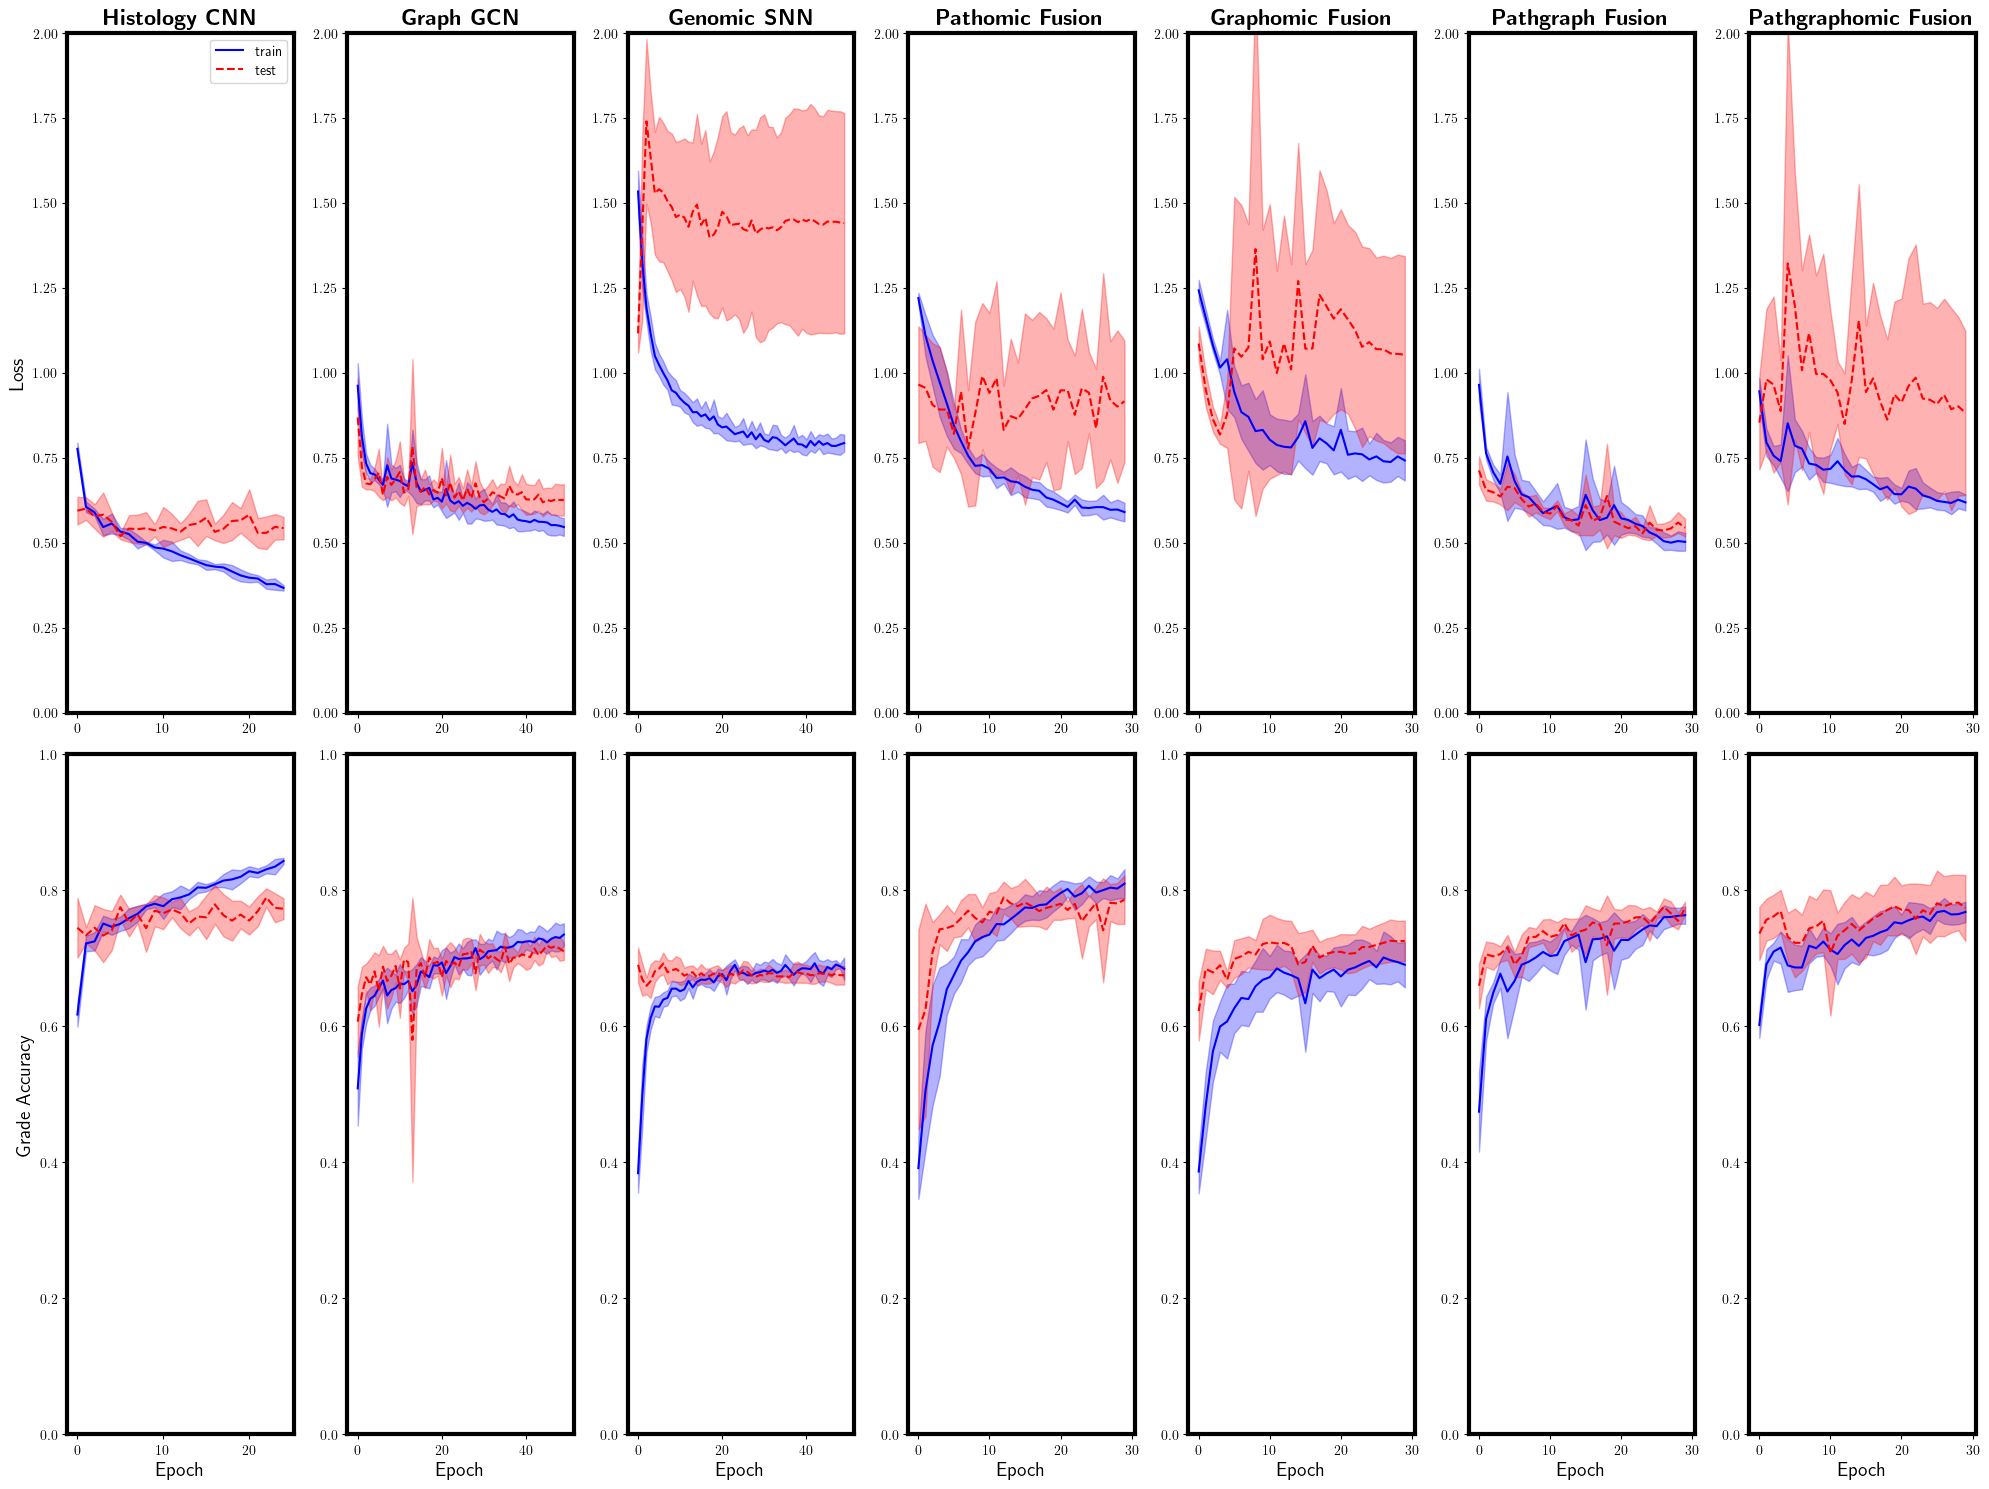

In [2]:
#### LOSS & METRIC PLOTS - GRADE
metrics = ['loss', 'grad_acc']
model_names = ['path', 'graph', 'omic', 'pathomic_fusion', 'graphomic_fusion', 'pathgraph_fusion', 'pathgraphomic_fusion']
eval_folder = 'evaluation'

# Define relabeling dictionaries
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion',
    'graphomic_fusion': 'Graphomic Fusion',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion',
    'pathgraph_fusion': 'Pathgraph Fusion',
    'omicomic_fusion': 'Omicomic Fusion', 
    'pathpath_fusion': 'Pathpath Fusion',  
    'graphgraph_fusion': 'Graphgraph Fusion'  
}

metric_mapping = {
    'loss': 'Loss',
    'grad_acc': 'Grade Accuracy'
}

num_cols = len(model_names)
num_rows = 2 
exp_name = 'grad_15'
results = 'results'
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

train_color = 'blue'
test_color = 'red'

for metric_index, metric in enumerate(metrics):
    for i, model_name in enumerate(model_names):
        all_train_metrics = []
        all_test_metrics = []

        for k in range(1, 6):
            results_dir = os.path.join(checkpoints_dir, exp_name, results)
            csv_filepath = os.path.join(results_dir, f'{model_name}_metrics_{k}.csv')
            df = pd.read_csv(csv_filepath)

            train_metric = df[f'train_{metric}']
            test_metric = df[f'test_{metric}']

            all_train_metrics.append(train_metric)
            all_test_metrics.append(test_metric)

        # Calculate mean and std
        train_mean = np.mean(all_train_metrics, axis=0)
        train_std = np.std(all_train_metrics, axis=0)
        test_mean = np.mean(all_test_metrics, axis=0)
        test_std = np.std(all_test_metrics, axis=0)

        row = metric_index
        col = i

        ax = axes[row, col]
        epochs = range(len(train_mean))

        ax.plot(epochs, train_mean, label='train', color=train_color)
        ax.fill_between(epochs, train_mean - train_std, train_mean + train_std, color=train_color, alpha=0.3)

        ax.plot(epochs, test_mean, label='test', linestyle='--', color=test_color)
        ax.fill_between(epochs, test_mean - test_std, test_mean + test_std, color=test_color, alpha=0.3)

        if row == 0:
            ax.set_title(rf'$\textbf{{{model_mappings.get(model_name, model_name)}}}$', fontsize=16)
        if row == num_rows - 1:
            ax.set_xlabel('Epoch', fontsize=14)
        if col == 0:
            ax.set_ylabel(metric_mapping.get(metric, metric), fontsize=14)
        if col == 0 and metric_index == 0:
            ax.legend()
        if metric == 'loss':
            ax.set_ylim(0, 2)
        elif metric == 'grad_acc':
            ax.set_ylim(0, 1)

plt.tight_layout()

# Create the directory if it does not exist
os.makedirs(os.path.join(checkpoints_dir, eval_folder), exist_ok=True)

# Save the plot
plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'{exp_name}_grade_losses_gbmlgg.png')
plt.savefig(plot_filepath)
plt.show()

In [3]:
#### Summary tables for the grade metrics for TCGA-GBMLGG
# Define relabeling dictionaries
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion (CNN+SNN)',
    'graphomic_fusion': 'Graphomic Fusion (GCN+SNN)',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion (CNN+GCN+SNN)',
    'pathgraph_fusion': 'Pathgraph Fusion (CNN+GCN)',
    'omicomic_fusion': 'Omicomic Fusion (SNN+SNN)', 
    'pathpath_fusion': 'Pathpath Fusion (CNN+CNN)',  
    'graphgraph_fusion': 'Graphgraph Fusion (GCN+GCN)'  
}
# List of model names
model_names = ['path','graph','omic','pathomic_fusion','graphomic_fusion','pathgraph_fusion', 'pathgraphomic_fusion']

# Initialize list to store metrics
metrics_list = []

for idx, model in enumerate(model_names):
    for k in range(1, 6):
        # Get predictions
        y_label, y_pred = getPredAggGrad_GBMLGG(k, model=model, agg_type='max') 
        y_label = np.squeeze(y_label)
        y_pred = np.squeeze(y_pred)

        # Compute ROC area for each class
        auc_val = roc_auc_score(y_label, y_pred)

        # Convert logits to probabilities using softmax
        y_pred_prob = softmax(y_pred, axis=1)

        # Binarize the predicted probabilities (threshold=0.5)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        ap = average_precision_score(y_label, y_pred_prob)

        # F1 score calculation
        f1 = f1_score(y_label, y_pred_binary, average = 'micro')

        # F1 score calculation for grade IV by extracting the relevant column
        f1_grade_iv = f1_score(y_label[:,2], y_pred_binary[:,2], average = 'micro')

        # Append the metrics to the list
        metrics_list.append({
            'Model': model_mappings[model],
            'AUC': auc_val,
            'AP': ap,
            'F1-Score (Micro)': f1,
            'F1-Score (Grade IV)': f1_grade_iv
        })


# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# # Display the DataFrame
# print(metrics_df)

# Compute average and standard deviation
avg_metrics = metrics_df.groupby('Model').mean().reset_index()
std_metrics = metrics_df.groupby('Model').std().reset_index()

# Rename columns for clarity
avg_metrics.columns = ['Model', 'Mean AUC', 'Mean AP', 'Mean F1-Score (Micro)', 'Mean F1-Score (Grade IV)']
std_metrics.columns = ['Model', 'Stdev AUC', 'Stdev AP', 'Stdev F1-Score (Micro)', 'Stdev F1-Score (Grade IV)']

# Merge mean and std into a single DataFrame
metrics_summary = pd.merge(avg_metrics, std_metrics, on='Model')

# Format standard deviation values to more decimal places
metrics_summary = metrics_summary.round({'Stdev AUC': 4, 'Stdev AP': 4, 'Stdev F1-Score (Micro)': 4, 'Stdev F1-Score (Grade IV)': 4})

# Display the summarized metrics
print(metrics_summary)

                                Model  Mean AUC   Mean AP  \
0                         Genomic SNN  0.807571  0.609871   
1                           Graph GCN  0.857788  0.706830   
2          Graphomic Fusion (GCN+SNN)  0.867079  0.705593   
3                       Histology CNN  0.873109  0.732673   
4          Pathgraph Fusion (CNN+GCN)  0.889795  0.764240   
5  Pathgraphomic Fusion (CNN+GCN+SNN)  0.899006  0.756393   
6           Pathomic Fusion (CNN+SNN)  0.893656  0.750632   

   Mean F1-Score (Micro)  Mean F1-Score (Grade IV)  Stdev AUC  Stdev AP  \
0               0.656763                  0.860153     0.0217    0.0553   
1               0.666179                  0.872645     0.0124    0.0211   
2               0.715734                  0.896489     0.0244    0.0593   
3               0.704426                  0.890018     0.0288    0.0499   
4               0.724476                  0.908947     0.0168    0.0288   
5               0.746208                  0.922600     0.0322

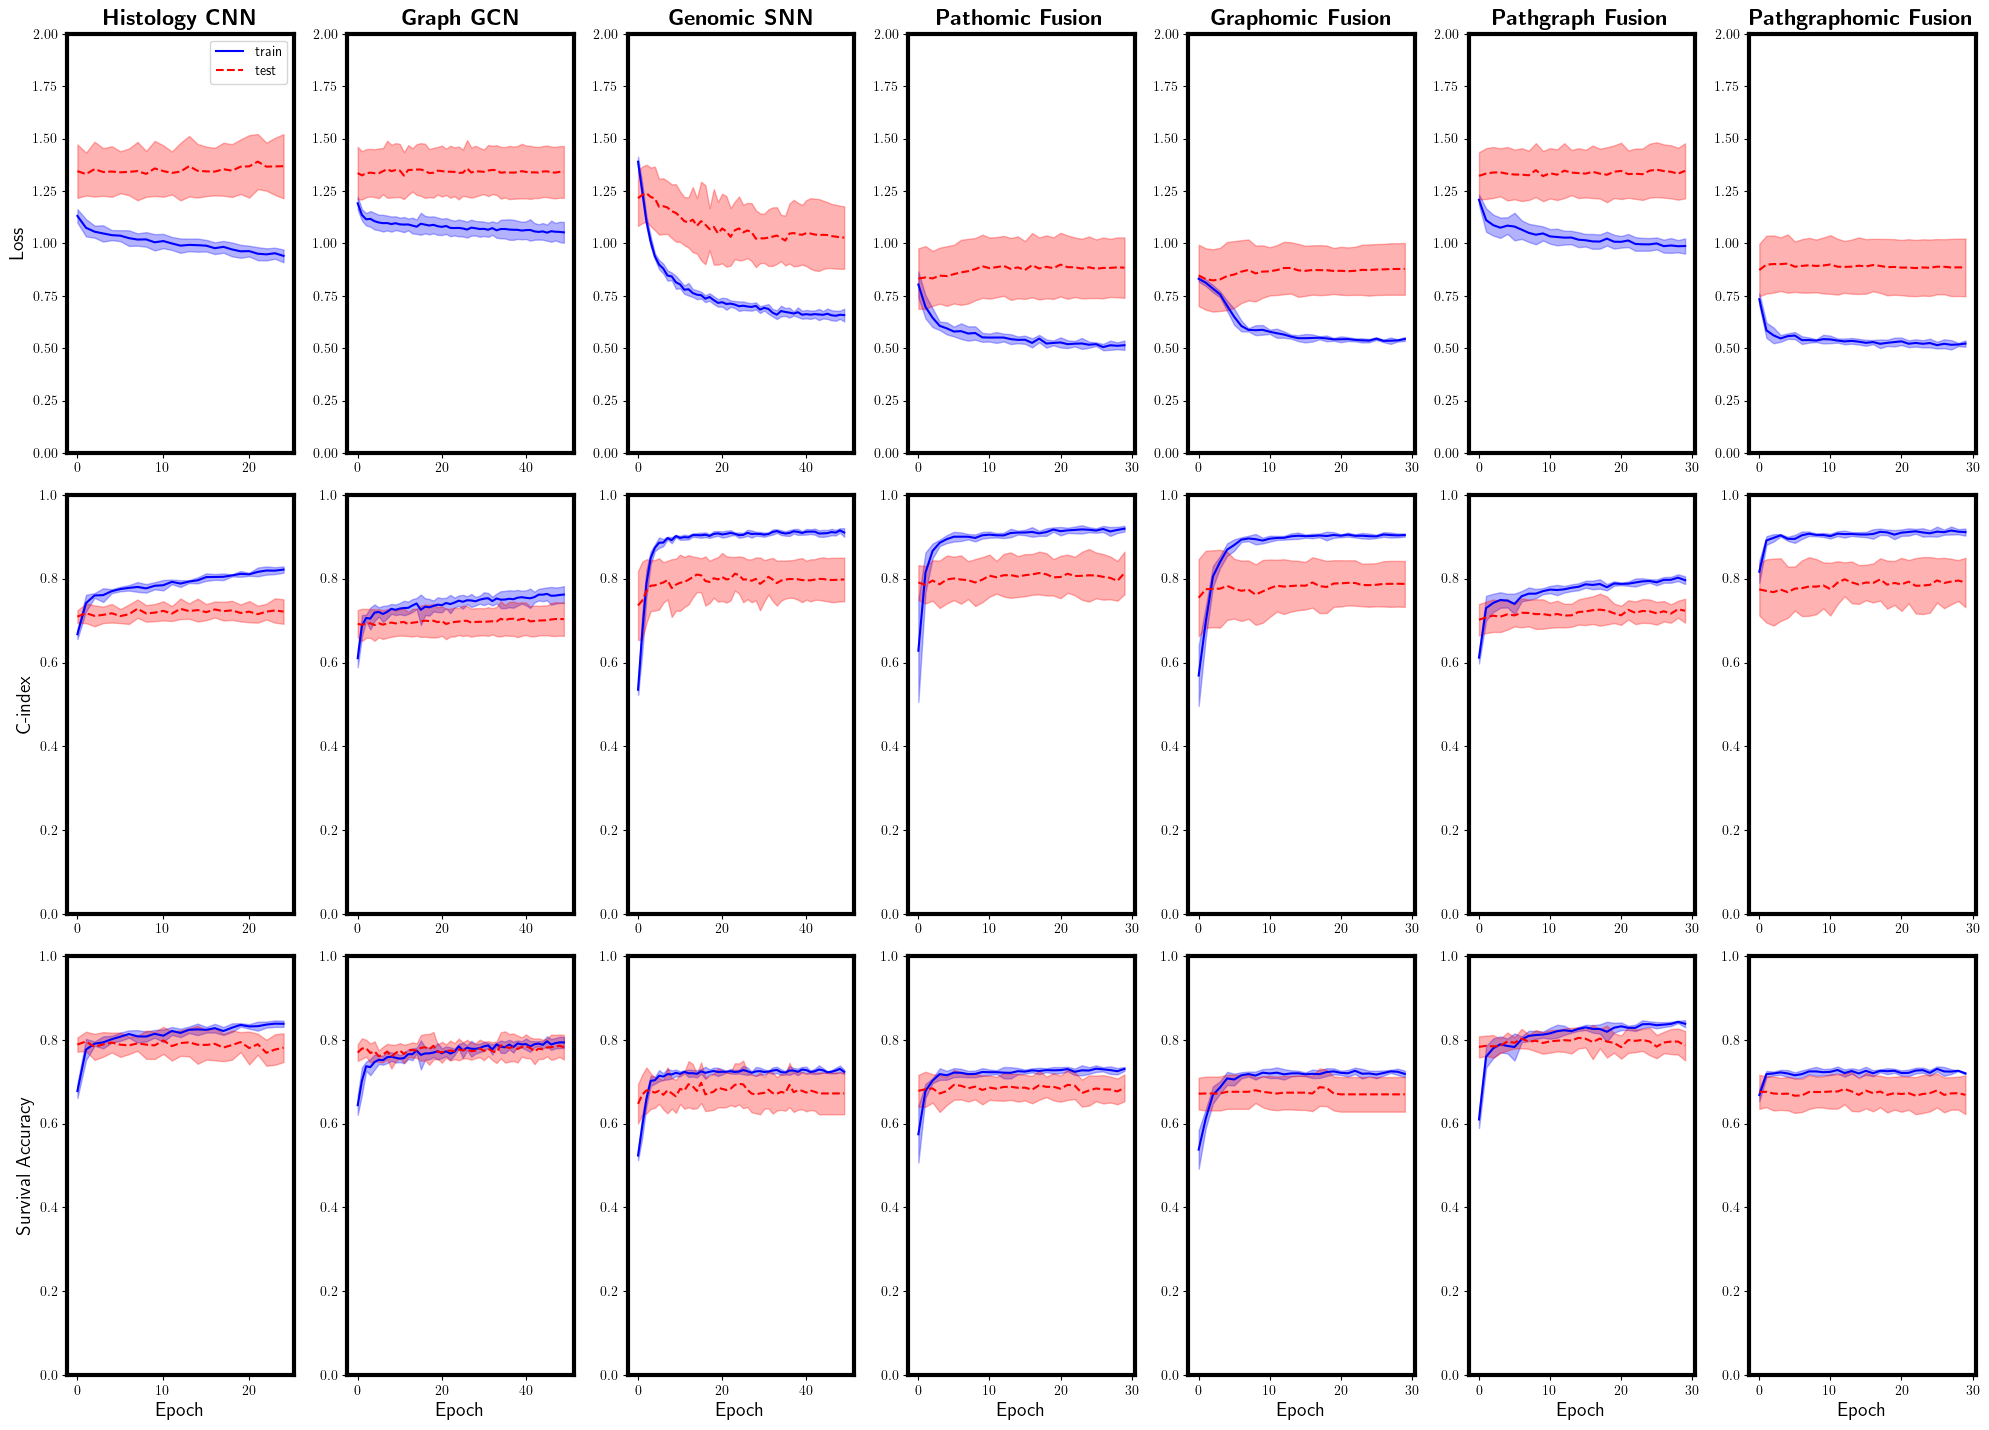

In [4]:
#### LOSS & METRIC PLOTS - SURVIVAL ####
checkpoints_dir = './checkpoints/TCGA_GBMLGG'
metrics = ['loss', 'cindex', 'surv_acc']
eval_folder = 'evaluation'

# List of model names
model_names = ['path', 'graph', 'omic', 'pathomic_fusion', 'graphomic_fusion', 'pathgraph_fusion', 'pathgraphomic_fusion']

# Define relabeling dictionaries
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion',
    'graphomic_fusion': 'Graphomic Fusion',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion',
    'pathgraph_fusion': 'Pathgraph Fusion',
    'omicomic_fusion': 'Omicomic Fusion', 
    'pathpath_fusion': 'Pathpath Fusion',  
    'graphgraph_fusion': 'Graphgraph Fusion'  
}
metric_mapping = {
    'loss': 'Loss',
    'cindex': 'C-index',
    'surv_acc': 'Survival Accuracy'
}

checkpoints_dir = './checkpoints/TCGA_GBMLGG'
metrics = ['loss', 'cindex', 'surv_acc']
eval_folder = 'evaluation'
results = 'results'

# Calculate the number of rows and columns for the grid
num_cols = len(model_names)
num_rows = 3  # We have three rows of metrics

exp_name = 'surv_15_rnaseq'

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

train_color = 'blue'
test_color = 'red'

for metric_index, metric in enumerate(metrics):
    for i, model_name in enumerate(model_names):
        all_train_metrics = []
        all_test_metrics = []

        for k in range(1, 6):
            results_dir = os.path.join(checkpoints_dir, exp_name, results)
            csv_filepath = os.path.join(results_dir, f'{model_name}_metrics_{k}.csv')
            df = pd.read_csv(csv_filepath)

            train_metric = df[f'train_{metric}']
            test_metric = df[f'test_{metric}']

            all_train_metrics.append(train_metric)
            all_test_metrics.append(test_metric)

        # Calculate mean and std
        train_mean = np.mean(all_train_metrics, axis=0)
        train_std = np.std(all_train_metrics, axis=0)
        test_mean = np.mean(all_test_metrics, axis=0)
        test_std = np.std(all_test_metrics, axis=0)

        row = metric_index
        col = i

        ax = axes[row, col]
        epochs = range(len(train_mean))

        ax.plot(epochs, train_mean, label='train', color=train_color)
        ax.fill_between(epochs, train_mean - train_std, train_mean + train_std, color=train_color, alpha=0.3)

        ax.plot(epochs, test_mean, label='test', linestyle='--', color=test_color)
        ax.fill_between(epochs, test_mean - test_std, test_mean + test_std, color=test_color, alpha=0.3)

        if row == 0:
            ax.set_title(rf'$\textbf{{{model_mappings.get(model_name, model_name)}}}$', fontsize=16)
        if row == num_rows - 1:
            ax.set_xlabel('Epoch', fontsize=14)
        if col == 0:
            ax.set_ylabel(metric_mapping.get(metric, metric), fontsize = 14)
        if col == 0 and metric_index == 0:
            ax.legend()
        if metric == 'loss':
            ax.set_ylim(0, 2)
        elif metric == 'surv_acc':
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Create the directory if it does not exist
os.makedirs(os.path.join(checkpoints_dir, eval_folder), exist_ok=True)

# Save the plot
plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'{exp_name}_performance_plot_surv_gbmlgg.png')
plt.savefig(plot_filepath)


In [6]:
#### Summary tables for c-indexes for survival for TCGA-GBMLGG #### 
# Define relabeling dictionaries
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion (CNN+SNN)',
    'graphomic_fusion': 'Graphomic Fusion (GCN+SNN)',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion (CNN+GCN+SNN)',
    'pathgraph_fusion': 'Pathgraph Fusion (CNN+GCN)',
    'omicomic_fusion': 'Omicomic Fusion (SNN+SNN)', 
    'pathpath_fusion': 'Pathpath Fusion (CNN+CNN)',  
    'graphgraph_fusion': 'Graphgraph Fusion (GCN+GCN)'  
}
# List of model names
model_names = ['path','graph','omic','pathomic_fusion','graphomic_fusion','pathgraph_fusion', 'pathgraphomic_fusion']

# Initialize list to store metrics
metrics_list = []

# Extract metrics for each model
for model in model_names:
    results_loc = os.path.join(checkpoints_dir, 'surv_15_rnaseq', model, f'{model}_5_results.pkl')
    with open(results_loc, 'rb') as f:
        results = pickle.load(f)
        metrics_list.append({
            "Model": model,
            "Mean C-index": np.mean(results),
            "Standard Deviation": np.std(results)
        })

# Create DataFrame
summary_df = pd.DataFrame(metrics_list)

# Display DataFrame
print(summary_df)


                  Model  Mean C-index  Standard Deviation
0                  path      0.720992            0.022110
1                 graph      0.703496            0.040011
2                  omic      0.798098            0.052117
3       pathomic_fusion      0.802934            0.043578
4      graphomic_fusion      0.787477            0.054785
5      pathgraph_fusion      0.718602            0.023739
6  pathgraphomic_fusion      0.796474            0.052041


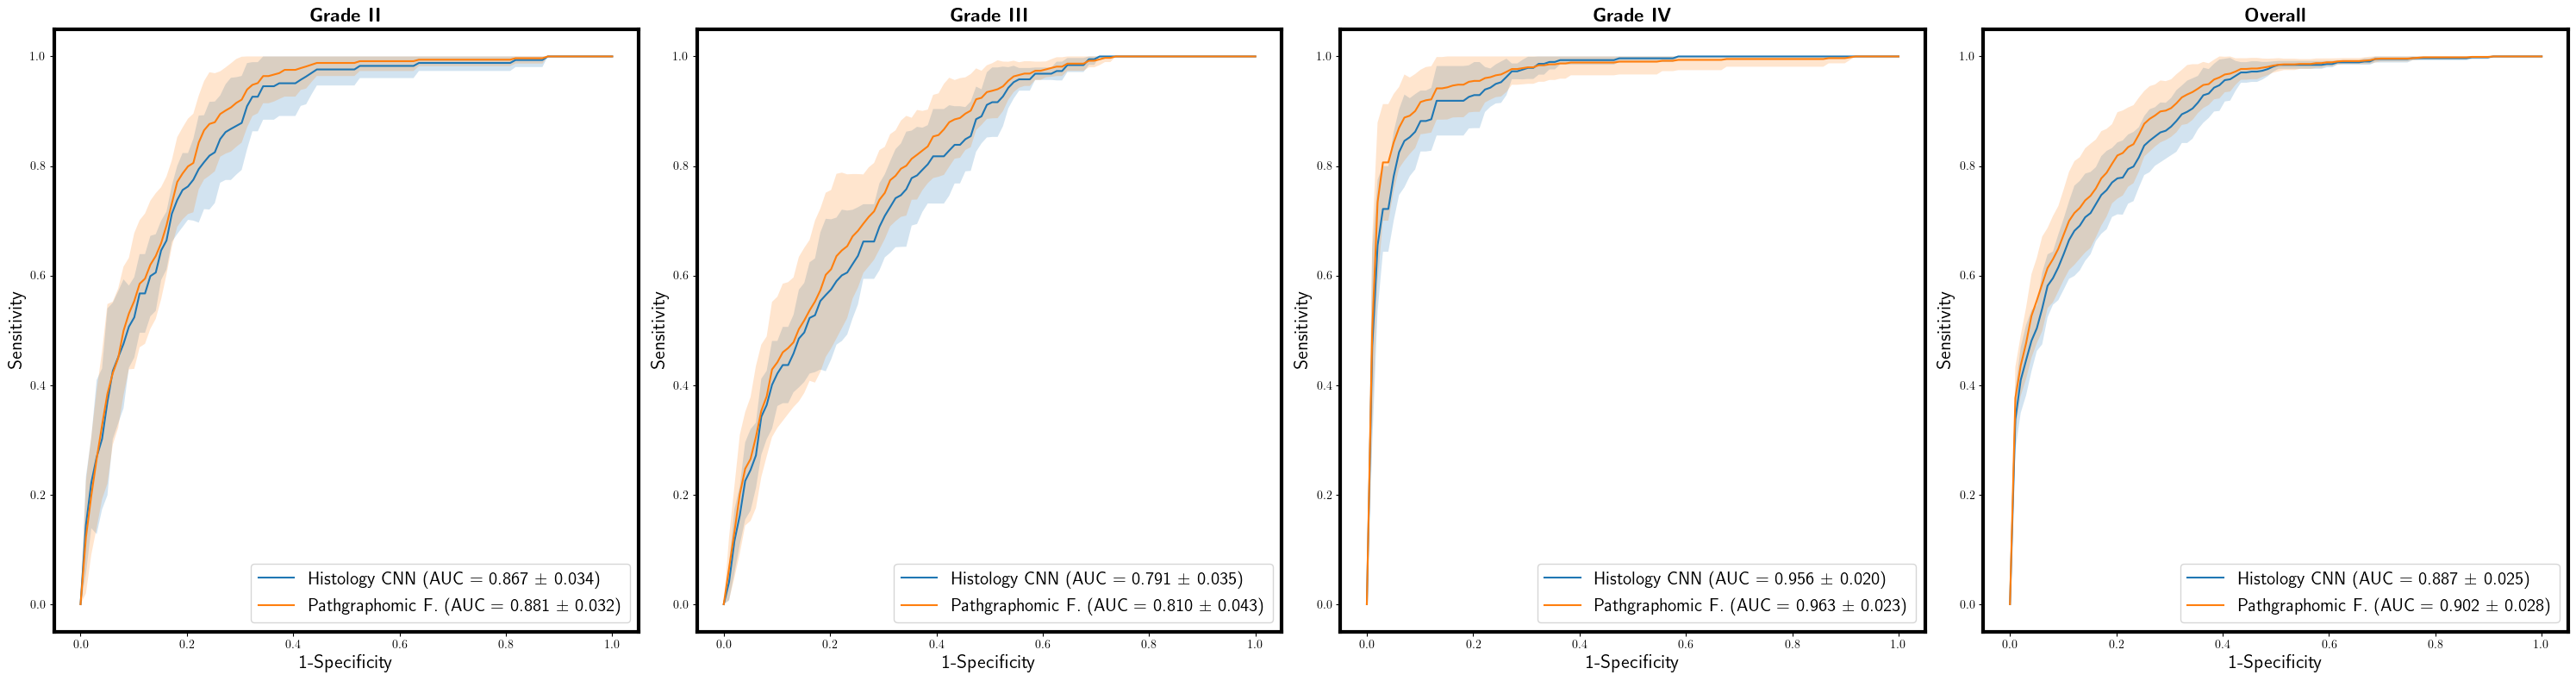

In [12]:
#### ROC, AUC Plots for the path and pathgraphomic fusion models ####
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

grade_mappings = {
    '2': 'II',
    '3': 'III',
    '4': 'IV'
}

# Models and grades
model_names = ['path',  'pathgraphomic_fusion']
grades = [2, 3, 4]
eval_folder = 'evaluation'

# Initialize plot
fig, axes = plt.subplots(1, len(grades) + 1, figsize=(30, 8))
axes = axes.flatten()

for idx, grade in enumerate(grades + ['overall']):
    ax = axes[idx]
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    for model in model_names:
        for k in range(1, 6):
            # Get predictions
            y_label, y_pred = getPredAggGrad_GBMLGG(k=k, model=model, agg_type='max') 
            y_label = np.squeeze(y_label)
            y_pred = np.squeeze(y_pred)
            
            if grade != 'overall':
                y_label = y_label[:, grades.index(grade)]
                y_pred = y_pred[:, grades.index(grade)]
            
            fpr, tpr, _ = roc_curve(y_label.ravel(), y_pred.ravel())
            roc_auc = auc(fpr, tpr)
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        ax.plot(mean_fpr, mean_tpr, label=f'{model_mappings[model]} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
    
    ax.set_title(rf'$\textbf{{Grade {grade_mappings.get(str(grade), grade)}}}$' if grade != 'overall' else rf'$\textbf{{Overall}}$', fontsize=16)
    ax.set_xlabel('1-Specificity', fontsize=16)
    ax.set_ylabel('Sensitivity', fontsize=16)
    ax.legend(loc='lower right', fontsize=15)

# Adjust the spacing between subplots
plt.tight_layout()
plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'roc_curves_path_pgo.png')
plt.savefig(plot_filepath)
plt.show()
plt.close()

# Missing Molecular Subtype: 6
# Missing IDH Mutation: 6
# Missing 1p19q Codeletion: 6
# Missing Histological Subtype: 32
# Missing Grade: 32
[<matplotlib.lines.Line2D object at 0x15fe618d0>, <matplotlib.lines.Line2D object at 0x17a8c2c80>, <matplotlib.lines.Line2D object at 0x17a8c3e50>, <matplotlib.lines.Line2D object at 0x17a8c37f0>, <matplotlib.lines.Line2D object at 0x17a8c2fb0>, <matplotlib.lines.Line2D object at 0x17a8c2410>] ['Grade II', 'Grade III', 'Grade IV', 'Graph GCN (Low)', 'Graph GCN (Mid)', 'Graph GCN (High)']
# Missing Molecular Subtype: 6
# Missing IDH Mutation: 6
# Missing 1p19q Codeletion: 6
# Missing Histological Subtype: 32
# Missing Grade: 32
[<matplotlib.lines.Line2D object at 0x15ff49ae0>, <matplotlib.lines.Line2D object at 0x17a8c0bb0>, <matplotlib.lines.Line2D object at 0x17a8c0be0>, <matplotlib.lines.Line2D object at 0x17a8c2050>, <matplotlib.lines.Line2D object at 0x17aa2a170>, <matplotlib.lines.Line2D object at 0x17aa28550>] ['Grade II', 'Grade III', 'Gra

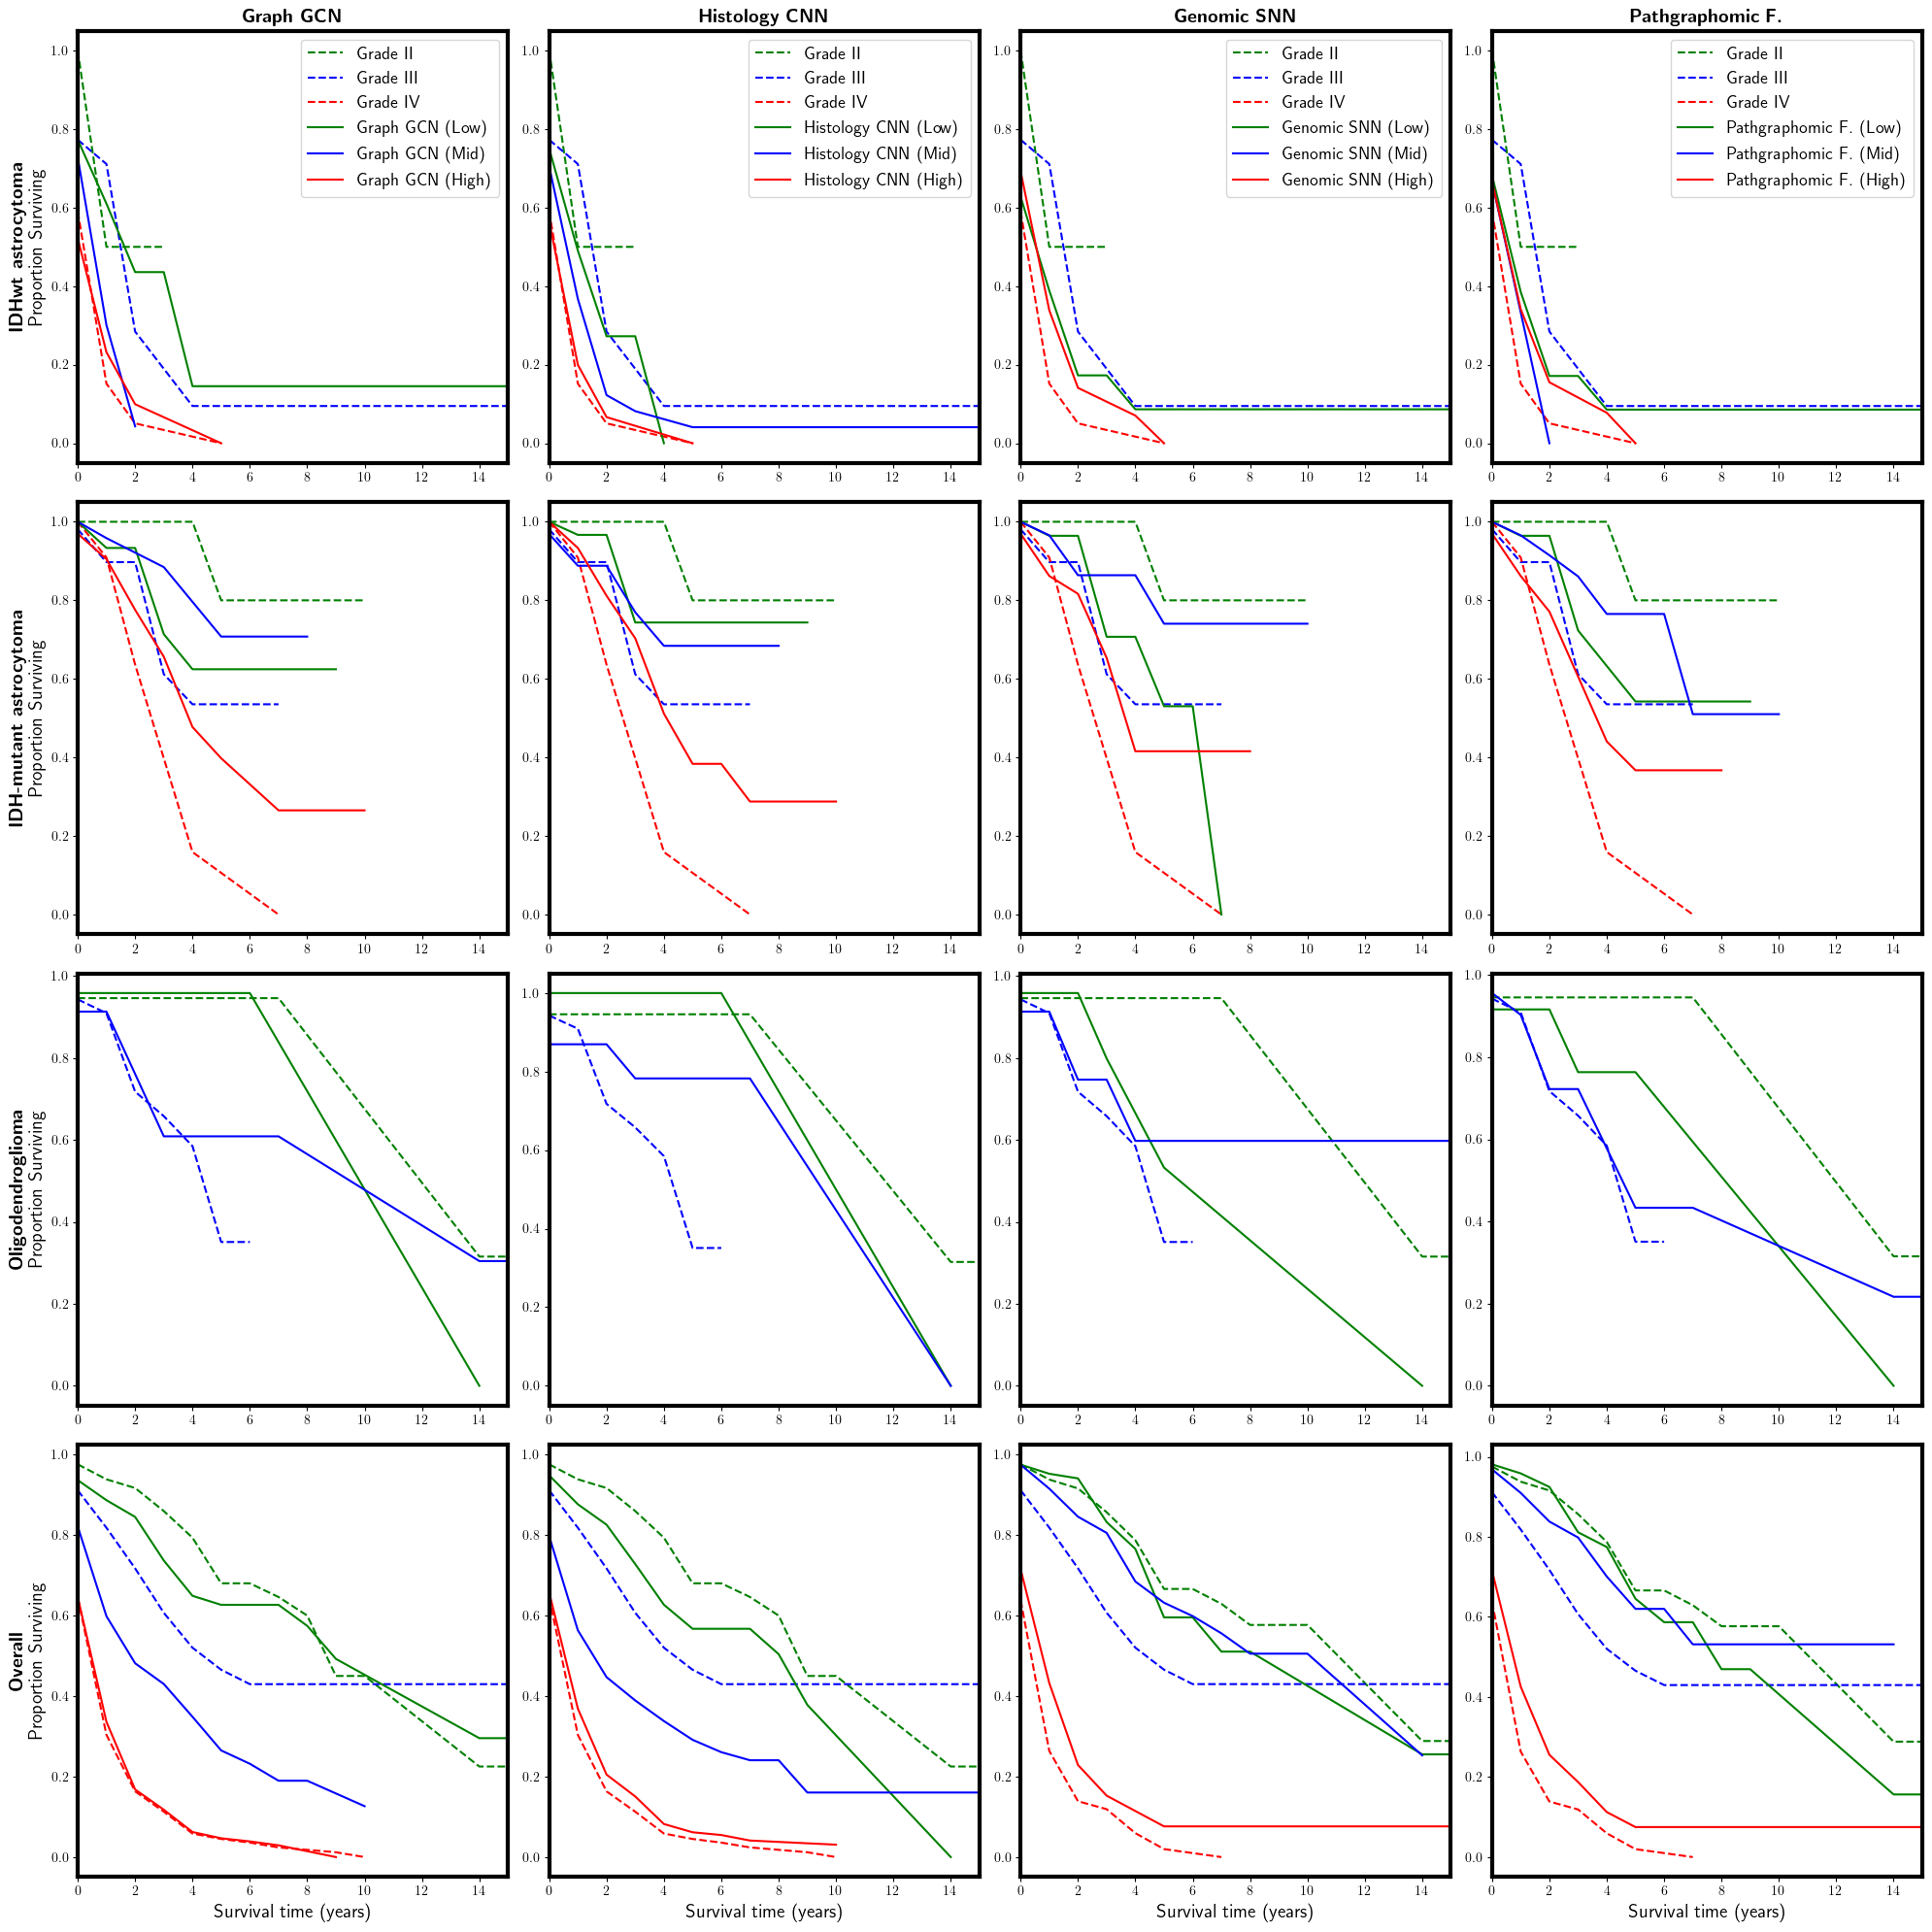

In [13]:
#### Kaplan Meier plots by molecular subtype ####
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion (CNN+SNN)',
    'graphomic_fusion': 'Graphomic Fusion (GCN+SNN)',
    'pathgraphomic_fusion': 'Pathgraphomic F.',
    'pathgraph_fusion': 'Pathgraph Fusion (CNN+GCN)',
    'omicomic_fusion': 'Omicomic Fusion (SNN+SNN)', 
    'pathpath_fusion': 'Pathpath Fusion (CNN+CNN)',  
    'graphgraph_fusion': 'Graphgraph Fusion (GCN+GCN)'  
}

# Load the data
df1 = pd.read_csv('./data/TCGA_GBMLGG/all_dataset.csv')
df2 = pd.read_csv('./data/TCGA_GBMLGG/grade_data.csv')
df = df1.merge(df2, on='TCGA ID', how='left') 

models = ['graph', 'path', 'omic', 'pathgraphomic_fusion']

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

grade_mapping = {
    0: 'Low',
    1: 'Mid',
    2: 'High'
}

grade_mapping_rome = {
    0: 'II',
    1: 'III',
    2: 'IV'

}

for j, model in enumerate(models):
    data_saver = []
    for k in range(1, 6):
        data = load_and_process_survival_data(model, k, '_', 'test', ckpt_name=f'./checkpoints/TCGA_GBMLGG/surv_15_rnaseq')
        data_saver.append(data)
    data = pd.concat(data_saver, ignore_index=True)
    data['TCGA ID'] = data['Patient ID']
    data_merge = data.merge(df, on='TCGA ID', how='left')
    full_data = data_merge.copy()
    model_name = model_mappings.get(model, 'Unknown Model')
    
    
    metadata, all_datasetc = getCleanAllDataset(use_rnaseq=True)
    all_dataset = all_datasetc.copy()
    astro_wt_ids = all_dataset.loc[all_dataset.iloc[:, 0] == 'idhwt_ATC', 'TCGA ID'].values
    all_dataset = all_datasetc.copy()
    astro_mut_ids = all_dataset.loc[all_dataset.iloc[:, 0] == 'idhmut_ATC', 'TCGA ID'].values
    all_dataset = all_datasetc.copy()
    oligodendro_ids = all_dataset.loc[all_dataset.iloc[:, 0] == 'ODG', 'TCGA ID'].values

    # Filter the full_data DataFrame by the extracted IDs
    datasets = {
        r'\textbf{IDHwt astrocytoma}': full_data[full_data['TCGA ID'].isin(astro_wt_ids)],
        r'\textbf{IDH-mutant astrocytoma}': full_data[full_data['TCGA ID'].isin(astro_mut_ids)],
        r'\textbf{Oligodendroglioma}': full_data[full_data['TCGA ID'].isin(oligodendro_ids)],
        r'\textbf{Overall}': full_data
    }

    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        grade_status = dataset['Grade Status']
        hazards = dataset['Hazards']
        censor_status = dataset['Censor Status']
        survival_times = dataset['Survival Time']
        survival_times = survival_times // 365
        kmf = KaplanMeierFitter()

        thresholds = [33, 66, 100]
        percentiles_of_hazards = np.percentile(hazards, thresholds)
        grade_status_predicted = np.array([hazard2grade(h, percentiles_of_hazards) for h in hazards])

        colours = ['green', 'blue', 'red']
        for grade, color in zip([0, 1, 2], colours):
            mask = (grade_status == grade)
            if mask.any():
                kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask], label=f'Grade {grade+2}')
                axs[i, j].plot(kmf.survival_function_, linestyle="--", color=color, label=f'Grade {grade_mapping_rome[grade]}')
                if j == 0:
                    axs[i, j].set_ylabel(f'{dataset_name}\nProportion Surviving', fontsize=14)

        for grade, color in zip([0, 1, 2], colours):
            if grade == 2:
                mask = (grade_status_predicted == 2) | (grade_status_predicted == 3)
            else:
                mask = (grade_status_predicted == grade)
            if dataset_name == r'\textbf{Oligodendroglioma}' and grade == 2:
                continue  # Skip plotting for grade 2 in Oligodendro
            
            if mask.any():
                kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
                axs[i, j].plot(kmf.survival_function_, linestyle="-", color=color, label=f'{model_name} ({grade_mapping[grade]})')
                axs[i, j].set_xlim([0, 15])
                if i == 0:
                    axs[i, j].set_title(rf'\textbf{{{model_name}}}', fontsize=14)
        if i==1:
            # Collect legend handles and labels for each plot in the first row
            handle, label = axs[i, j].get_legend_handles_labels()
            print(handle, label)
            axs[0, j].legend(handle, label, loc='upper right', fontsize=13)

        if i == 3:
            axs[i, j].set_xlabel('Survival time (years)', fontsize=14)

plt.tight_layout()
plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'km_curves_four.png')
plt.savefig(plot_filepath)


# Missing Molecular Subtype: 6
# Missing IDH Mutation: 6
# Missing 1p19q Codeletion: 6
# Missing Histological Subtype: 32
# Missing Grade: 32


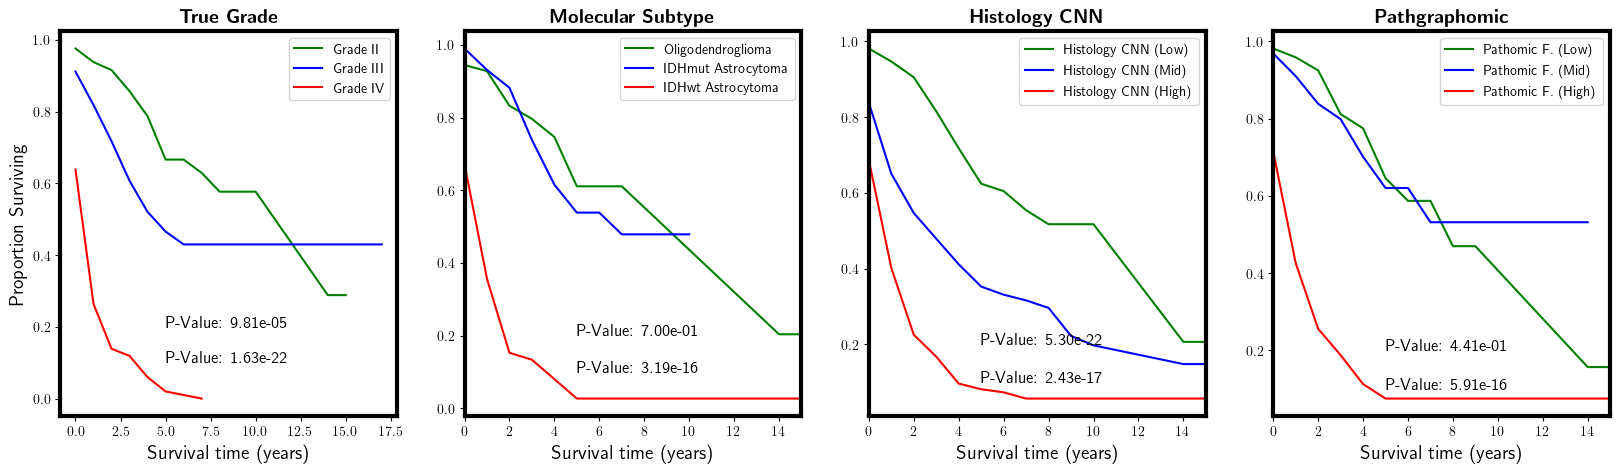

In [15]:
#### Kaplan- Meier Curves for all models splitting by grade, mutation status, and the hazards from the histology CNN and pathgraphomic f. networks ####
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion (CNN+SNN)',
    'graphomic_fusion': 'Graphomic Fusion (GCN+SNN)',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion (CNN+GCN+SNN)',
    'pathgraph_fusion': 'Pathgraph Fusion (CNN+GCN)',
    'omicomic_fusion': 'Omicomic Fusion (SNN+SNN)', 
    'pathpath_fusion': 'Pathpath Fusion (CNN+CNN)',  
    'graphgraph_fusion': 'Graphgraph Fusion (GCN+GCN)'  
}

mol_subtype_mapping = {
    'idhwt_ATC': 'IDHwt Astrocytoma',
    'idhmut_ATC': 'IDHmut Astrocytoma',
    'ODG': 'Oligodendroglioma'
}

histology_mapping = {
    '0': 'Low',
    '1': 'Mid',
    '2': 'High'
}

grade_mapping = {
    '0': 'II',
    '1': 'III',
    '2': 'IV'
}

# Adding data for idh mutation status
metadata, all_dataset = getCleanAllDataset(use_rnaseq=True)
all_dataset = all_dataset.reset_index(drop=True)

split = 'test'
use_patch = '_'
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
model = 'pathgraphomic_fusion'
model_name = model_mappings.get(model, 'Unknown Model') 
data_saver= []

# Retrieve the data for pltting and convert the hazard values to stratification categories
def km_data_organiser(model):
    for k in range(1,6):
        data = load_and_process_survival_data(model, k, use_patch, split, ckpt_name='./checkpoints/TCGA_GBMLGG/surv_15_rnaseq')
        data_saver.append(data)
    data = pd.concat(data_saver, ignore_index=True)
    data['TCGA ID'] = data['Patient ID']
    data_merge = data.merge(all_dataset, on='TCGA ID', how='left')
    full_data = data_merge.copy()
    grade_status = full_data['Grade Status']
    hazards = full_data['Hazards']
    censor_status = full_data['Censor Status']
    survival_times = full_data['Survival Time'] // 365
    mutation_status = full_data['Histomolecular subtype']
    thresholds = [33, 66, 100]
    # Assign grades to hazard values
    percentiles_of_hazards = np.percentile(hazards, thresholds)
    # Assign grades to hazard values based on percentiles
    grade_status_predicted = np.array([hazard2grade(h, percentiles_of_hazards) for h in hazards])
    return grade_status, grade_status_predicted, hazards, censor_status, survival_times, mutation_status

# Kaplan-Meier curve by grade status
kmf = KaplanMeierFitter()
grade_status, grade_status_predicted, hazards, censor_status, survival_times, mutation_status = km_data_organiser('pathgraphomic_fusion')
colours = ['green', 'blue', 'red']

# First plot for survival by true grade status
for grade, color in zip([0,1,2], colours):
    mask = (grade_status == grade)
    kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
    kmf.survival_function_
    axs[0].plot(kmf.survival_function_, linestyle="-", color=color, label=f'Grade {grade_mapping.get(str(grade))}')   
    axs[0].set_title(rf'$\textbf{{True Grade}}$', fontsize=14)
    # Perform log-rank test
    if grade < 2:  # Compare with next grade
        next_grade_mask = (grade_status == grade + 1)
        results = logrank_test(survival_times[mask], survival_times[next_grade_mask], event_observed_A=censor_status[mask], event_observed_B=censor_status[next_grade_mask])
        p_value_text = f'P-Value: {results.p_value:.2e}'
        axs[0].text(5, 0.2 - 0.1*grade, p_value_text, fontsize=12, color='black')

# Second plot for survival by mutation status 
for mut_status, color in zip(["ODG","idhmut_ATC","idhwt_ATC"], colours):
    mask = (mutation_status == mut_status)
    kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
    # kmf.plot_survival_function(ci_show=False, color=color, linestyle='--')
    kmf.survival_function_
    axs[1].plot(kmf.survival_function_, linestyle="-", color=color, label = mol_subtype_mapping.get(mut_status, mut_status))
    axs[1].set_xlim([0, 15])
    axs[1].set_title(rf'$\textbf{{Molecular Subtype}}$', fontsize=14)

# Perform log-rank test for molecular subtypes
odg_mask = (mutation_status == "ODG")
idhmut_mask = (mutation_status == "idhmut_ATC")
idhwt_mask = (mutation_status == "idhwt_ATC")

results_odg_idhmut = logrank_test(survival_times[odg_mask], survival_times[idhmut_mask], event_observed_A=censor_status[odg_mask], event_observed_B=censor_status[idhmut_mask])
results_odg_idhwt = logrank_test(survival_times[odg_mask], survival_times[idhwt_mask], event_observed_A=censor_status[odg_mask], event_observed_B=censor_status[idhwt_mask])

p_values_text = [
    f'P-Value: {results_odg_idhmut.p_value:.2e}',
    f'P-Value: {results_odg_idhwt.p_value:.2e}',
]

for i, text in enumerate(p_values_text):
    axs[1].text(5, 0.2 - 0.1*i, text, fontsize=12, color='black')

grade_status_path, grade_status_predicted_path, hazards_path, censor_status_path, survival_times_path, mutation_status_path = km_data_organiser('path')

# Third plot stratifying by hazards from path network
for grade, color in zip([0,1,2], colours):
    if grade ==2:
        grade = 2 or 3
    mask = (grade_status_predicted_path == grade)
    kmf.fit(durations=survival_times_path[mask], event_observed=censor_status_path[mask])
    # kmf.plot_survival_function(ci_show=False, color=color, linestyle='--')
    kmf.survival_function_
    axs[2].plot(kmf.survival_function_, linestyle="-", color=color, label=f'Histology CNN ({histology_mapping.get(str(grade), str(grade))})')
    axs[2].set_xlim([0, 15])
    axs[2].set_title(rf'$\textbf{{Histology CNN}}$', fontsize=14)
    # Perform log-rank test
    if grade < 2:  # Compare with next grade
        next_grade_mask = (grade_status_predicted_path == grade + 1)
        results = logrank_test(survival_times_path[mask], survival_times_path[next_grade_mask], event_observed_A=censor_status_path[mask], event_observed_B=censor_status_path[next_grade_mask])
        p_value_text = f'P-Value: {results.p_value:.2e}'
        axs[2].text(5, 0.2 - 0.1*grade, p_value_text, fontsize=12, color='black')

# Fourth plot stratifying by hazards from pathomic fusion network
for grade, color in zip([0,1,2], colours):
    if grade == 2:
        mask = (grade_status_predicted == 2) | (grade_status_predicted == 3)
    else:
        mask = (grade_status_predicted == grade)
    kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
    kmf.survival_function_
    axs[3].plot(kmf.survival_function_, linestyle="-", color=color, label=f'Pathomic F. ({histology_mapping.get(str(grade), str(grade))})')
    axs[3].set_xlim([0, 15])
    axs[3].set_title(rf'$\textbf{{Pathgraphomic}}$', fontsize=14)

    # Perform log-rank test
    if grade < 2:  # Compare with next grade
        next_grade_mask = (grade_status_predicted == grade + 1)
        results = logrank_test(survival_times[mask], survival_times[next_grade_mask], event_observed_A=censor_status[mask], event_observed_B=censor_status[next_grade_mask])
        p_value_text = f'P-Value: {results.p_value:.2e}'
        axs[3].text(5, 0.2 - 0.1*grade, p_value_text, fontsize=12, color='black')

# Setting the axis labels
for j in range(4):
    axs[j].set_xlabel('Survival time (years)', fontsize=14)
    axs[0].set_ylabel('Proportion Surviving', fontsize=14)
    axs[j].legend()

plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'kaplan_meier_curves_overall.png')
plt.show()
plt.savefig(plot_filepath)
plt.close()

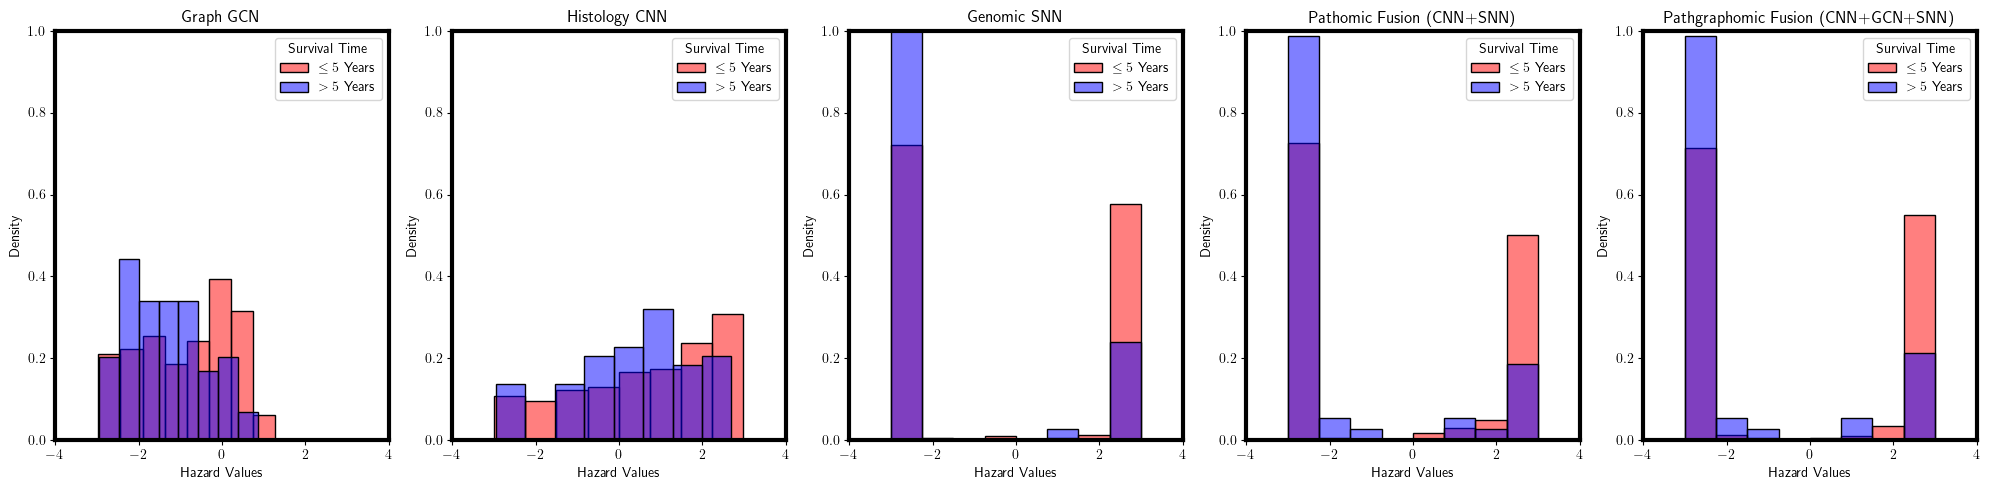

In [16]:
#### Histogram hazard plots by long and short survival
fig, axes = plt.subplots(1, 5, figsize=(20, 5)) 
for j, model in enumerate(['graph', 'path', 'omic', 'pathomic_fusion', 'pathgraphomic_fusion']):
    data_saver= []
    for k in range(1,6):
        split = 'test'
        data = load_and_process_survival_data(model, k, use_patch, split, ckpt_name='./checkpoints/TCGA_GBMLGG/surv_15_rnaseq')
        data_saver.append(data)

    data = pd.concat(data_saver, ignore_index=True)

    ax = axes[j]
    model_name = model_mappings.get(model, 'Unknown Model') 

    # Calculate the z-scores of the 'Hazards'
    data['Hazards_z'] = data['Hazards']

    # Split the data based on the survival time with low and high being thresholded by 5 years
    low = data[data['Survival Time'] <= 365*5]
    high = data[data['Survival Time'] > 365*5]

    # Histogram plotting with normalized density using plt directly
    sns.histplot(low['Hazards_z'], ax=ax,bins=8, kde=False, stat="density", color="red", alpha=0.5, edgecolor="black", label=r'$\leq 5$ Years')
    sns.histplot(high['Hazards_z'], ax=ax, bins=8,kde=False, stat="density",color="blue", alpha=0.5, edgecolor="black", label=r'$> 5$ Years')

    # Adjusting the visual layout of the plot
    ax.set_xlabel('Hazard Values')
    ax.set_ylabel('Density')
    ax.set_xlim([-4, 4])
    ax.set_ylim([0, 1])

    # Title for each subplot
    ax.set_title(f'{model_name}')

    # Adding legend to each subplot
    ax.legend(title="Survival Time")

# Adjust layout to prevent overlapping
plt.tight_layout()   
plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'hazard_histograms.png')
plt.show()
plt.savefig(plot_filepath)
plt.close()

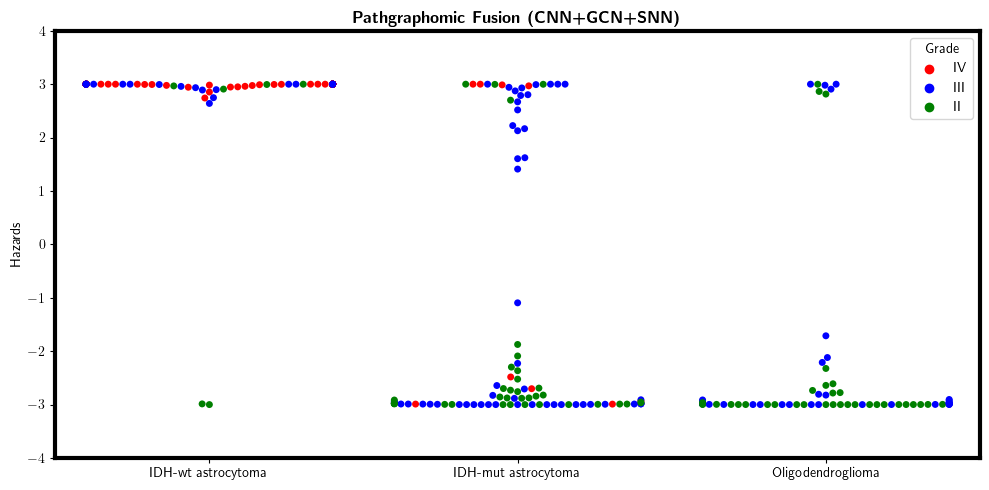

<Figure size 640x480 with 0 Axes>

In [18]:
#### HAZARD SWARM PLOTS BY MODEL
# Define model mappings
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion (CNN+SNN)',
    'graphomic_fusion': 'Graphomic Fusion (GCN+SNN)',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion (CNN+GCN+SNN)',
    'pathgraph_fusion': 'Pathgraph Fusion (CNN+GCN)',
    'omicomic_fusion': 'Omicomic Fusion (SNN+SNN)', 
    'pathpath_fusion': 'Pathpath Fusion (CNN+CNN)',  
    'graphgraph_fusion': 'Graphgraph Fusion (GCN+GCN)'  
}

# Load datasets
df1 = pd.read_csv('./data/TCGA_GBMLGG/all_dataset.csv')
df2 = pd.read_csv('./data/TCGA_GBMLGG/grade_data.csv')
df = df1.merge(df2, on='TCGA ID', how='left') 

split = 'test'
use_patch = '_'
fig, ax = plt.subplots(figsize=(10, 5))

# Convert grade to Roman numerals
def grade_to_roman(grade):
    roman_numerals = {2: 'II', 3: 'III', 4: 'IV'}
    return roman_numerals.get(grade, str(grade))

def data_for_swarm(model):
    data_saver = []
    for k in range(1, 6):
        data = load_and_process_survival_data(model, k, use_patch, split, ckpt_name='./checkpoints/TCGA_GBMLGG/surv_15_rnaseq')
        data_saver.append(data)
    data = pd.concat(data_saver, ignore_index=True)
    data['TCGA ID'] = data['Patient ID']
    data_merge = data.merge(df, on='TCGA ID', how='left')
    full_data = data_merge.copy()
    data = full_data

    # Filter data by tumor type
    metadata, all_dataset = getCleanAllDataset(use_rnaseq=True)
    astro_wt_ids = all_dataset.loc[all_dataset.iloc[:, 0] == 'idhwt_ATC', 'TCGA ID'].values
    astro_mut_ids = all_dataset.loc[all_dataset.iloc[:, 0] == 'idhmut_ATC', 'TCGA ID'].values
    oligodendro_ids = all_dataset.loc[all_dataset.iloc[:, 0] == 'ODG', 'TCGA ID'].values

    astro_wt_data = full_data[full_data['TCGA ID'].isin(astro_wt_ids)]
    astro_mut_data = full_data[full_data['TCGA ID'].isin(astro_mut_ids)]
    oligodendro_data = full_data[full_data['TCGA ID'].isin(oligodendro_ids)]

    # Combine data for plotting
    combined_data = pd.concat([
        astro_wt_data.assign(TumorType='IDH-wt astrocytoma'),
        astro_mut_data.assign(TumorType='IDH-mut astrocytoma'),
        oligodendro_data.assign(TumorType='Oligodendroglioma')
    ])

    combined_data['Grade'] = combined_data['Grade'].apply(grade_to_roman)

    # Calculate z-scores overall
    combined_data['Hazard (z-score)'] = combined_data['Hazards']
    return combined_data

model = 'pathgraphomic_fusion'
combined_data = data_for_swarm(model)
model_name = model_mappings.get(model, 'Unknown Model')

# Plotting using swarmplot
sns.swarmplot(data=combined_data, x='TumorType', y='Hazard (z-score)', hue='Grade', 
            palette={'II': 'green', 'III': 'blue', 'IV': 'red'}, ax=ax, size=5)

ax.set_title(rf'$\textbf{{{model_name}}}$')
ax.set_xlabel('')
ax.set_ylabel('Hazards')
ax.set_ylim(-4, 4)
ax.legend(title='Grade')
plt.tight_layout()
plot_filepath = os.path.join('./checkpoints/TCGA_GBMLGG/', 'evaluation', f'hazard_swarm_{model}.png')
plt.show()
plt.savefig(plot_filepath)


In [20]:
model = 'path'
combined_data_path = data_for_swarm(model)
model_name = model_mappings.get(model, 'Unknown Model')

# Plotting using swarmplot
sns.swarmplot(data=combined_data_path, x='TumorType', y='Hazard (z-score)', hue='Grade', 
            palette={'II': 'green', 'III': 'blue', 'IV': 'red'}, ax=ax, size=5)

ax.set_title(rf'$\textbf{{{model_name}}}$')
ax.set_xlabel('')
ax.set_ylabel('Hazards')
ax.set_ylim(-4, 4)
ax.legend(title='Grade')
plt.tight_layout()
plot_filepath = os.path.join('./checkpoints/TCGA_GBMLGG/', 'evaluation', f'hazard_swarm_{model}.png')
plt.savefig(plot_filepath)

<Figure size 640x480 with 0 Axes>